BE/Bi 103, Fall 2014: Homework 7
================================
Due 1pm, Monday, December 8
---------------------------

*This document was generated from an IPython notebook.  You can download the notebook [here](hw7.ipynb).*

In [49]:
# As usual, import modules
from __future__ import division, absolute_import, print_function

import os
    
import numpy as np
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import scipy.ndimage
import skimage.io
import skimage.filter
import skimage.morphology
import skimage.segmentation

import seaborn as sns
sns.set()

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

### Problem 7.1 (Caulobacter growth, 60 pts)

In this problem, we will study the growth and division of *Caulobacter crescentus* over time.  The lab of [Norbert Scherer](http://schererlab.uchicago.edu) at the University of Chicago acquired these data and recently published the work in PNAS, which you can download [here](http://bebi103.caltech.edu/2014/protected/papers/iyer-biswas_2014.pdf).

The clever experimental set-up allows imaging of single dividing cells in conditions that are identical through time.  This is accomplished by taking advantage of a unique morphological feature of *Caulobacter*.  The mother cell is adherent to the a surface through its stalk.  Upon division, one of the daughter cells does not have a stalk and is mobile.  The system is part of a microfluidic device that gives a constant flow.  So, every time a mother cell divides, the un-stalked daughter cell gets washed away.  In such a way, the dividing cells are never in a crowded environment and the buffer is always fresh.  This also allows for easier segmentation.

The data were sent to you via Dropbox.  They were kindly provided by Charlie Wright in the Scherer lab.  The frame rate is 1 frame per minute.  The interpixel spacing is 0.052 µm.  All images were acquired at 24 $^\circ$C.

As with any of the problems in this class, you are encouraged to explore the data beyond what is asked for specifically in the problems statements.  The paper is also a very interesting read.

**a)** The directory `sequential_full_field` contains 10 sequential frames of a full field of bacteria in the microfluidic device.  From these frames, choose which bacteria would be good to use to gather long time course imaging.  I.e., choose those that you think will give minimal errors in segmentation.  Give your reasoning, including images demonstrating segmentation.

**b)** The files `bacterium_1.tif` and `bacterium_2.tif` are TIFF stacks of time courses for specific cells in from the full field images.  From these time courses, compute the time scale of division of the cells.  In other words, compute the time between divisions for each division for each cell and plot the results.  Comment on any interesting aspects of these data.

**c)** In their paper, the authors argue that the growth rate of the cell is exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{\kappa t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0\kappa$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth rate.  Use the model selection methods we learned in class to assess the relative probabilites that the growth rate is exponential versus linear.

### Problem 7.1 solution

In [58]:
data_dir = '../data/iyer-biswas_et_al/hw7_data_1'
fname = os.path.join(data_dir, 'bacterium_2.tif')
calo_xyt = jb.XYTStack(fname, dt=1.0, physical_size_x=0.052, 
                       physical_size_y=0.052)

In [20]:
def our_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """
    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filter.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

In [48]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filter.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)


Processing 1 of 8699...
Processing 101 of 8699...
Processing 201 of 8699...
Processing 301 of 8699...
Processing 401 of 8699...
Processing 501 of 8699...
Processing 601 of 8699...
Processing 701 of 8699...
Processing 801 of 8699...
Processing 901 of 8699...
Processing 1001 of 8699...
Processing 1101 of 8699...
Processing 1201 of 8699...
Processing 1301 of 8699...
Processing 1401 of 8699...
Processing 1501 of 8699...
Processing 1601 of 8699...
Processing 1701 of 8699...
Processing 1801 of 8699...
Processing 1901 of 8699...
Processing 2001 of 8699...
Processing 2101 of 8699...
Processing 2201 of 8699...
Processing 2301 of 8699...
Processing 2401 of 8699...
Processing 2501 of 8699...
Processing 2601 of 8699...
Processing 2701 of 8699...
Processing 2801 of 8699...
Processing 2901 of 8699...
Processing 3001 of 8699...
Processing 3101 of 8699...
Processing 3201 of 8699...
Processing 3301 of 8699...
Processing 3401 of 8699...
Processing 3501 of 8699...
Processing 3601 of 8699...
Processing 37

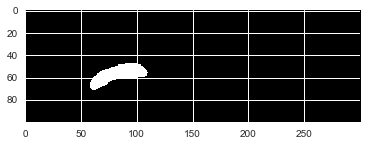

In [59]:
# Use JB thresholding to get areas
areas = np.empty(calo_xyt.size_t)
for i in range(calo_xyt.size_t):
    if i % 100 == 0:
        print('Processing %d of %d...' % (i+1, calo_xyt.size_t))
    
    im = calo_xyt.im(i)
    # Using JB filter (problem with stalk
#    im_bw, k_opt = our_thresh(im, skimage.morphology.disk(25), 
#                              white_true=False, min_size=300)

    # Straight up Otsu
    im_bw = im < skimage.filter.threshold_otsu(im)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    areas[i] = im_bw.sum() * calo_xyt.physical_size_x**2

    # Label binary image; backward kwarg says value in im_bw to consider backgr.
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    

skimage.io.imshow(im_bw, cmap=cm.gray)

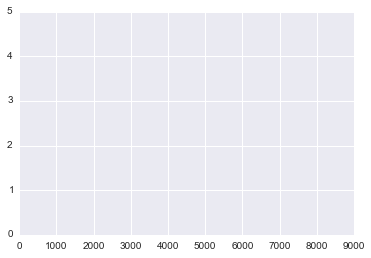

In [60]:
plt.plot(calo_xyt.t, areas, 'k.', markersize=2)
plt.savefig('areas.pdf')

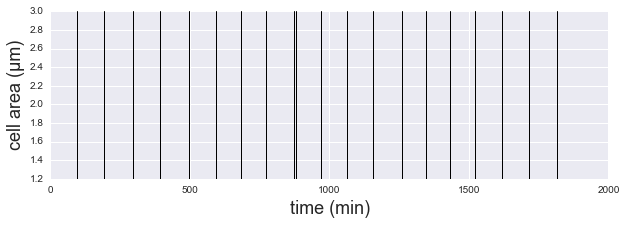

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filter import threshold_otsu
from skimage.segmentation import clear_border
import jb_utils as jb
sns.set()

# Load XYT tiff stack
xyt = jb.XYTStack('bacterium.tif', dt=1.0, physical_size_x=0.052)

# Threshold and compute cell areas
areas = np.empty(xyt.size_t)
for i in range(xyt.size_t):
    im_bw = clear_border(xyt.im(i) < threshold_otsu(xyt.im(i)), buffer_size=9)
    areas[i] = im_bw.sum() * xyt.physical_size_x**2

# Detect outliers and division events
good_points = (areas[1:] < 5.0) & (areas[1:] > 1.0) & (np.diff(areas) < 0.1)
div_events = np.nonzero(np.diff(areas[1:][good_points]) < -0.6)[0]

# Plot results
fig = plt.figure(figsize=(10, 3))
plt.plot(xyt.t[good_points], areas[good_points], '.', color='#6A3D9A')
for i in range(len(div_events)):
    plt.axvline(xyt.t[good_points][div_events[i]] - 0.5, lw=1)
plt.xlabel('time (min)', fontsize=18)
plt.ylabel(u'cell area (µm)', fontsize=18)
plt.savefig('caulo_growth.pdf', bbox_inches='tight')

In [109]:
1 / 0.052

19.23076923076923

<br />
<br />

### Problem 7.2 (Colocalization of piRNA-related proteins, 40 pts)

Alex Webster from Alexei Aravin's lab discussed his study of colocalization of key proteins with Aubergine, a protein involved in the selective silencing of transposons in germ cells in the *Drosophila* egg chamber via piRNA pathways.  Among the three proteins he talked about are Krimper, Tudor, and Zucchini.  The former two are implicated in the ping-pong cycle that optimizes piRNA response.  It is thought that Zucchini is a nuclease that aids in constructing piRNA complexes.

In this problem, we will quantify the colocalization of these three proteins with Aubergine.  Aubergine is labeled with mKate2, a deep red fluorophore, and Krimper, Tudor, and Zucchini are labeled with GFP.  Alex has kindly provided us with three sets of images for each of the three constructs.  The data set can be downloaded [here](http://bebi103.caltech.edu/2014/protected/data/webster_et_al.zip).  The interpixel distance in these images is 0.162 µm.

Perform a colocalization analysis on these images and compare the colocalization between Aubergine and each the three proteins.

<br />
<br />

### Problem 7.3 (Your eyes are not as good as your computer, 5 pts extra credit)

Download the image below.  Use the basic image processing tools we learned in class to replace the beige and magenta colors with white and save the resulting image.  Display the original image and the altered image side by side.  (This problem was inspired by Dan White.)

[<img src="images/swirl.png">](http://bebi103.caltech.edu/2014/data/swirl.png)